In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from utils import EnhancerDataset, dna_one_hot, split_dataset,EnhancerDatasetWithID
import matplotlib.pyplot as plt
import torch.nn as nn
from upsetplot import plot
from venny4py.venny4py import *
from collections import Counter

from tangermeme.io import read_meme
from tangermeme.utils import random_one_hot, pwm_consensus
from tangermeme.marginalize import marginalize
from tangermeme.deep_lift_shap import deep_lift_shap
from tangermeme.seqlet import recursive_seqlets
from tangermeme.annotate import annotate_seqlets, count_annotations


import glob
import sys
sys.path.append('../model')  
from model import ExplaiNN3



In [31]:
def plot_delta(df, feature, topk = 10):
    # Sort by absolute values of Delta in descending order
    df = df.loc[df[feature].abs().sort_values(ascending=True).index]

    # Select the top 20 entries
    topk = df.head(topk)

    # Plotting
    plt.figure(figsize=(10, 8))

    # Colors for bars based on the sign of Delta
    colors = ['red' if delta > 0 else 'blue' for delta in topk[feature]]

    # Create horizontal bar plot
    plt.barh(topk['Motif_Name'], topk[feature].abs(), color=colors)

    # Add plot title and adjust layout
    plt.title(f'Attribution of different mus musculus TFs fot {feature}')
    plt.xlabel('Absolute Delta Values')
    plt.ylabel('Motif Names')
    plt.tight_layout()

    # Display the plot
    plt.show()
    
def find_cutoff(df, label, cutoff = 20, plot = True):
    if label not in ['G-', 'G+']:
        raise ValueError("Input Error: Label has to be 'G-' or 'G+'. ")
    df['Abs_Delta_G+'] = df['Delta_G+'].abs()
    df['Abs_Delta_G-'] = df['Delta_G-'].abs()
    df_Gpos_sorted = df.sort_values(by='Abs_Delta_G+', ascending = False).reset_index(drop = True)
    df_Gneg_sorted = df.sort_values(by='Abs_Delta_G-', ascending = False).reset_index(drop = True)
    # Sort the DataFrame by label in descending order
    if label == 'G+':
        sorted_values = df_Gpos_sorted['Abs_Delta_G+']
    elif label == 'G-':
        sorted_values = df_Gneg_sorted['Abs_Delta_G-']
    
    # Scatter plot for sorted label
    if plot == True:
        plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
        plt.plot(range(len(sorted_values)), sorted_values, marker = 'o', markersize = 2,linestyle='-', alpha=0.8)
        plt.axvline(x=cutoff, color='red', linestyle='--', linewidth=1)
        plt.xlabel("Sorted Index")
        plt.ylabel(f'Absolute Delta {label}')
        plt.grid(True)
        plt.show()

    if label == 'G+':
        return df_Gpos_sorted.iloc[:cutoff,:]
    elif label == 'G-':
        return df_Gneg_sorted.iloc[:cutoff,:]
    
def find_interect_ID(sets, num_intersect):
    # Combine all sets into a Counter to count occurrences across sets
    all_motifs = Counter()
    for motif_set in sets.values():
        all_motifs.update(motif_set)
        
    # Find names that occur in at least three sets
    motifs_intersect = {motif for motif, count in all_motifs.items() if count >= num_intersect}

    # Display the result
    print(f"Motif names occurring in at least {num_intersect} sets: {motifs_intersect}")

    return list(motifs_intersect)

def plot_attribution(dfs, motifs_intersect, label, plot_dir):
    # Step 1: Subset data frames
    subset_dfs = [df[df['Motif_ID'].isin(motifs_intersect)] for df in dfs]

    # Step 2: Create a new data frame from df1
    result_df = subset_dfs[0][['Motif_ID', 'Motif_Name', label]].copy()
    result_df.rename(columns={label: 'Rep1'}, inplace=True)

    # Step 3: Merge Delta_G+ columns from other data frames
    for i, df in enumerate(subset_dfs[1:], start=2):
        result_df = result_df.merge(df[['Motif_ID', label]], on='Motif_ID')
        result_df.rename(columns={label: f'Rep{i}'}, inplace=True)

    # Final Step: Plotting Attributions
    print(result_df.columns)
    # Calculate the mean across Rep1 to Rep5 columns
    result_df['Mean'] = result_df[['Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5']].mean(axis=1)

    # Sort the DataFrame based on the 'Mean' column in descending order
    result_df_sorted = result_df.sort_values(by='Mean', ascending=False)

    # Calculate standard deviation for error bars
    result_df_sorted['Std'] = result_df_sorted[['Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5']].std(axis=1)

    # Plot bar plot with error bars
    plt.figure(figsize=(12, 6))
    plt.bar(
        result_df_sorted['Motif_Name'],
        result_df_sorted['Mean'],
        yerr=result_df_sorted['Std'],
        capsize=5,
        alpha=0.7,
        ecolor='black'
    )

    # Add annotations
    plt.xlabel('Motif Name')
    plt.ylabel('Mean Attribution')
    plt.title(f'Mean Motif Attributions for {label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Display the plot
    plt.savefig(plot_dir, dpi=300, bbox_inches='tight')
    plt.show()
    return result_df

class ExpActivation(nn.Module):
    """
    Exponential activation function from Koo & Ploenzke, 2021 (PMID: 34322657)
    """
    def __init__(self):
        super(ExpActivation, self).__init__()
        self.saved_input = None  # Placeholder to save input during forward pass

    def forward(self, x):
        self.saved_input = x  # Save input for gradient calculation
        return torch.exp(x)
    
def exp_rescale_rule(module, grad_input, grad_output):
    # Gradient of exp(x) is exp(x)
    delta = torch.exp(module.saved_input)
    return (grad_output[0] * delta,)

def _nonlinear(module, grad_input, grad_output):
	"""An internal function implementing a general-purpose nonlinear correction.

	This function, copied and slightly modified from Captum, is meant to be
	the `rescale` rule applied to general non-linear functions such as
	activations.
	"""

	delta_in_ = torch.sub(*module.input.chunk(2))
	delta_out_ = torch.sub(*module.output.chunk(2))

	delta_in = torch.cat([delta_in_, delta_in_])
	delta_out = torch.cat([delta_out_, delta_out_])

	delta = delta_out / delta_in
	idxs = torch.abs(delta_in) < 1e-6

	return (torch.where(idxs, grad_input[0], grad_output[0] * delta),)


## Marginalization

### Generate background sequences

In [3]:
# Calculate ACGT nucleotide proportions from all dna sequences
# Load the CSV file
file_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_merged_data.csv'
data = pd.read_csv(file_path)

# Calculate the proportions of A, C, G, T in all DNA sequences
sequences = data['sequence']

# Initialize counters for A, C, G, T
total_counts = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
total_length = 0

for seq in sequences:
    total_counts['A'] += seq.count('A')
    total_counts['C'] += seq.count('C')
    total_counts['G'] += seq.count('G')
    total_counts['T'] += seq.count('T')
    total_length += len(seq)

# Calculate proportions
proportions = np.array([
    total_counts['A'] / total_length,
    total_counts['C'] / total_length,
    total_counts['G'] / total_length,
    total_counts['T'] / total_length
])
total = total_counts['A'] + total_counts['C'] + total_counts['G'] + total_counts['T']

print(proportions)

X = random_one_hot((14301, 4, 608), probs=np.array([[0.23270398,0.27106807,0.24121956,0.25500839]])).float()
print(X.shape)
#X.mean(dim=-1)[:5]

[0.23270398 0.27106807 0.24121956 0.25500839]
torch.Size([14301, 4, 608])


### Run marginalization for all trained models

In [9]:
motifs = read_meme("/pmglocal/ty2514/Enhancer/motif-clustering/databases/jaspar2024/JASPAR2024_CORE_vertebrates_mus_musculus_non-redundant_pfms_with_id.meme")
num_cnns = [20,60,75]
reps = [1]
result_dict = {}
for num_cnn in num_cnns:
    for rep in reps:
        print(f'Now processing CNN:{num_cnn}, Rep:{rep}')
        params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Metrics.csv')
        temp_df = params[params['num_cnns'] == num_cnn]

        group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
        best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
        # Extract the learning rate, dropout rate, and batch number for this best group
        best_lr = best_group['lr']
        best_dropout = best_group['drop_out']
        best_batch = best_group['batch']
        # Filter the original DataFrame to keep only the rows matching the best group
        best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                                (temp_df['drop_out'] == best_dropout) & 
                                (temp_df['batch'] == best_batch)]

        # Find the row with the highest 'pearson_corr_p' within this filtered group
        best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

        # Extract the seed with the highest 'pearson_corr_p' in the best group
        best_seed = int(best_seed_row['seed'])
        best_batch = int(best_batch)

        target_labels = ["GFP+","GFP-"]
        feature_list = ["G+","G-"]

        seed = best_seed
        batch = best_batch
        learning_rate= best_lr

        print(f'cnn: {num_cnn}')
        print(f'lr: {learning_rate}    drop_out: {best_dropout}')
        print(f'batch: {batch}    seed: {seed}')

        weight_folder = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/{num_cnn}NN_Rep{rep}'

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(device)
        # Initialize the model without moving it to the device yet
        explainn = ExplaiNN3(num_cnns=num_cnn, input_length=608, num_classes=2,
                            filter_size=19, num_fc=2, pool_size=7, pool_stride=7,
                            drop_out=0.3, weight_path=None)  # Training

        file_list = glob.glob(f'{weight_folder}/best_pearson*.pth')
        weight_file = file_list[0]
        print(f"Extracting from {weight_file}")
        state_dict = torch.load(weight_file, map_location=device)  # Load to the appropriate device
        # Load the modified state_dict into the model
        explainn.load_state_dict(state_dict)

        # Move the model to the appropriate device after loading the weights
        explainn.to(device)
        explainn.eval()

        ##### Run marginalization with the defined model
        names = []
        deltas_G_plus = []
        deltas_G_minus = []

        for name, pwm in motifs.items():
            consensus = pwm_consensus(pwm).unsqueeze(0)
            y_before, y_after = marginalize(explainn, X, consensus, device = 'cuda')
            
            # Calculate deltas for G+ and G-
            delta_G_plus = (y_after[:, 0] - y_before[:, 0]).mean().item()  # For G+
            delta_G_minus = (y_after[:, 1] - y_before[:, 1]).mean().item()  # For G-

            # Store results
            names.append(name)
            deltas_G_plus.append(delta_G_plus)
            deltas_G_minus.append(delta_G_minus)

            print(f"{name} - ΔG+: {delta_G_plus}, ΔG-: {delta_G_minus}")

        # Construct a data frame using names, delta_G_plus and delta_G_minus lists
        filtered_names = [name.split('.')[-1] for name in names]
        df = pd.DataFrame({'Motif_ID': names, 'Motif_Name': filtered_names, 'Delta_G+': deltas_G_plus, 'Delta_G-': deltas_G_minus})
        # Save result df to result_dict
        df_name = f'cnn{num_cnn}_rep{rep}'
        result_dict[df_name] = df
        # Saving the data frame
        #df.to_csv(f'/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/{num_cnn}NN_Rep{rep}_Attributions.csv', index= False)

Now processing CNN:20, Rep:1
cnn: 20
lr: 0.0005    drop_out: 0.3
batch: 96    seed: 350
cuda
Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/20NN_Rep1/best_pearson_model_epoch_123.pth
MA0004.1 MA0004.1.Arnt - ΔG+: 0.025097113102674484, ΔG-: 0.0255229864269495
MA0006.1 MA0006.1.Ahr::Arnt - ΔG+: 0.055127061903476715, ΔG-: 0.07511082291603088
MA0009.1 MA0009.1.Tbxt - ΔG+: 0.03593771532177925, ΔG-: 0.0380190908908844
MA0014.1 MA0014.1.Pax5 - ΔG+: -0.020337818190455437, ΔG-: -0.09148147702217102
MA0027.1 MA0027.1.En1 - ΔG+: -0.009495485574007034, ΔG-: 0.0031923025380820036
MA0029.1 MA0029.1.Mecom - ΔG+: 0.17525267601013184, ΔG-: 0.21113014221191406
MA0035.1 MA0035.1.Gata1 - ΔG+: 0.02925170585513115, ΔG-: 0.03136371821165085
MA0039.1 MA0039.1.Klf4 - ΔG+: 0.12679313123226166, ΔG-: 0.12334699183702469
MA0060.1 MA0060.1.NFYA - ΔG+: -0.11755851656198502, ΔG-: -0.16778253018856049
MA0105.1 MA0105.1.NFKB1 - ΔG+: 0.09948908537626266, ΔG-: 0.132603257894516
MA0063.1

### Analyze marginalization results for 20NN

In [26]:
df1 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/20NN_Rep1_Attributions.csv', sep = ',')
df2 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/20NN_Rep2_Attributions.csv', sep = ',')
df3 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/20NN_Rep3_Attributions.csv', sep = ',')
df4 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/20NN_Rep4_Attributions.csv', sep = ',')
df5 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/20NN_Rep5_Attributions.csv', sep = ',')


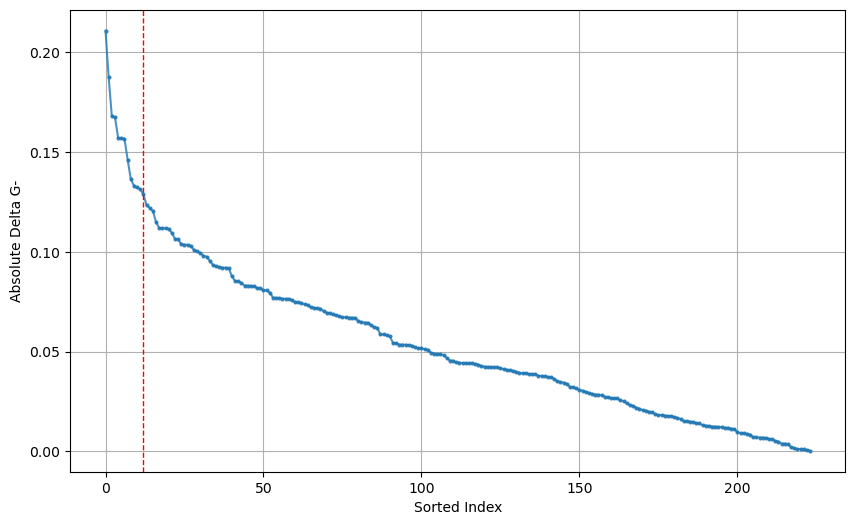

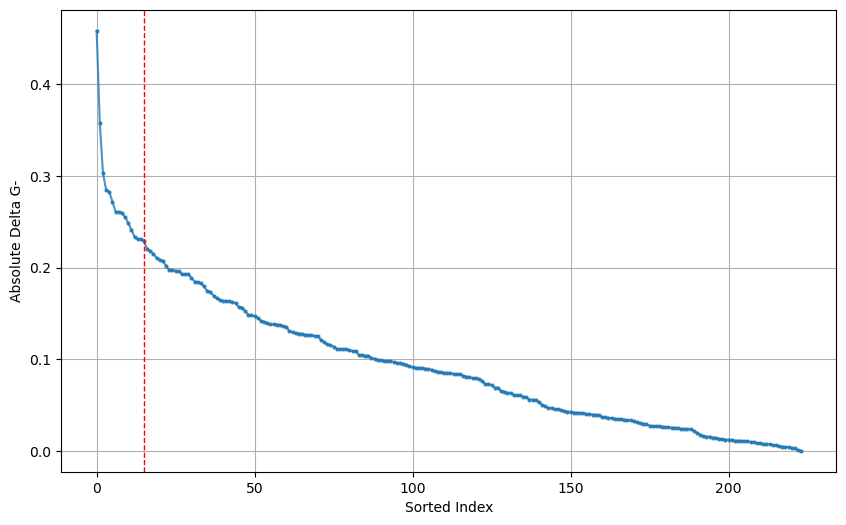

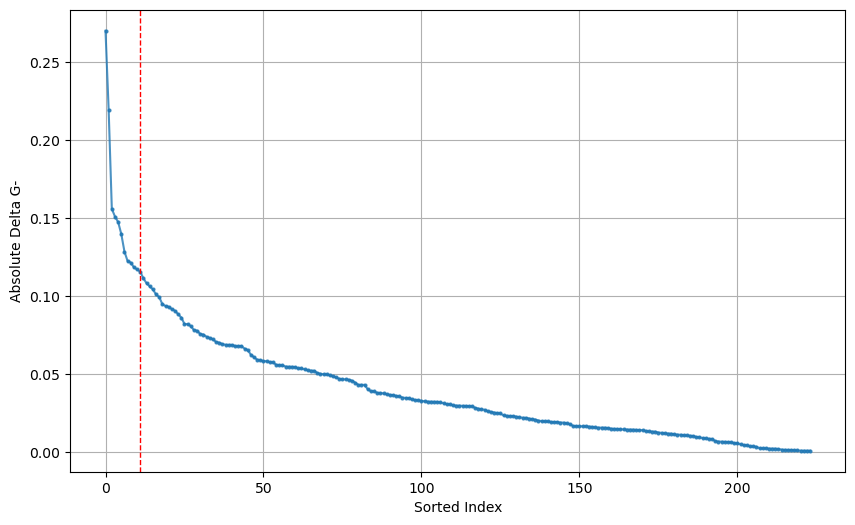

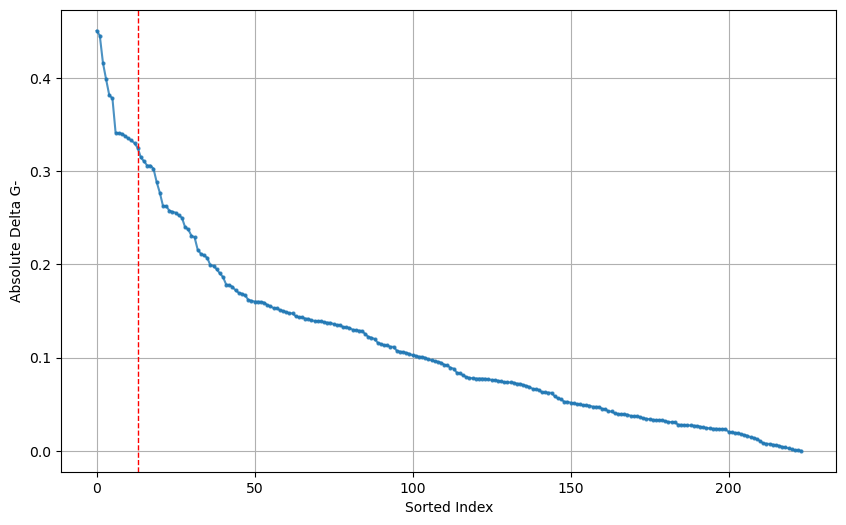

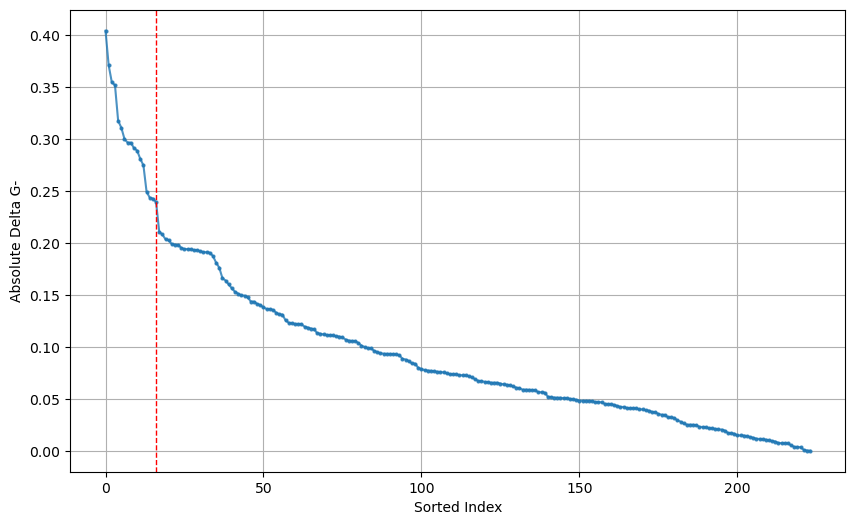

In [10]:
#sorted_df1 = find_cutoff(df1, 'G+', 12)
#sorted_df2 = find_cutoff(df2, 'G+', 10)
#sorted_df3 = find_cutoff(df3, 'G+', 11)
#sorted_df4 = find_cutoff(df4, 'G+', 11)
#sorted_df5 = find_cutoff(df5, 'G+', 12)

# For GFP+
sorted_df1_pos = find_cutoff(df1, 'G+', 12, plot = False)
sorted_df2_pos = find_cutoff(df2, 'G+', 10, plot = False)
sorted_df3_pos = find_cutoff(df3, 'G+', 11, plot = False)
sorted_df4_pos = find_cutoff(df4, 'G+', 11, plot = False)
sorted_df5_pos = find_cutoff(df5, 'G+', 12, plot = False)
# For GFP-
sorted_df1_neg = find_cutoff(df1, 'G-', 12)
sorted_df2_neg = find_cutoff(df2, 'G-', 15)
sorted_df3_neg = find_cutoff(df3, 'G-', 11)
sorted_df4_neg = find_cutoff(df4, 'G-', 13)
sorted_df5_neg = find_cutoff(df5, 'G-', 16)

/pmglocal/ty2514/miniforge3/envs/explainn/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/pmglocal/ty2514/miniforge3/envs/explainn/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

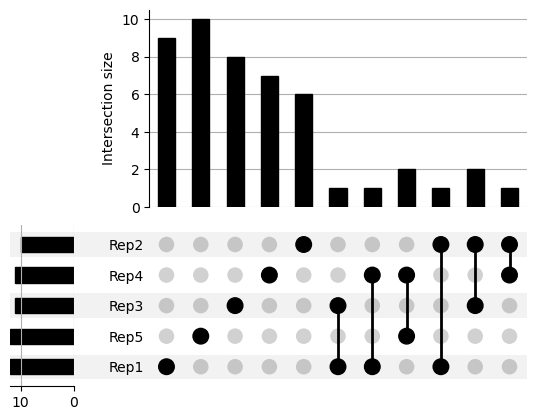

/pmglocal/ty2514/miniforge3/envs/explainn/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/pmglocal/ty2514/miniforge3/envs/explainn/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

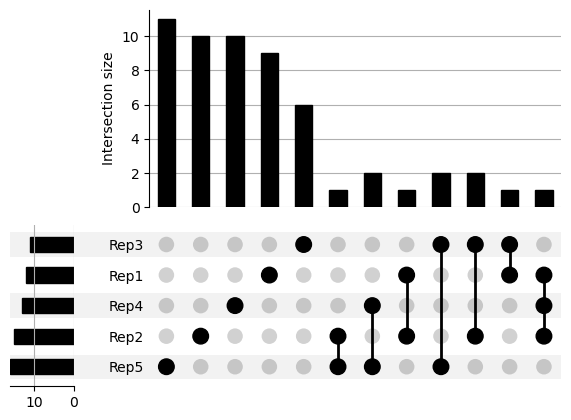

In [19]:
"""Plot upset plot"""
# GFP+
# Extract unique 'Motif_Name' values from each DataFrame
set1_pos = set(sorted_df1_pos['Motif_ID'])
set2_pos = set(sorted_df2_pos['Motif_ID'])
set3_pos = set(sorted_df3_pos['Motif_ID'])
set4_pos = set(sorted_df4_pos['Motif_ID'])
set5_pos = set(sorted_df5_pos['Motif_ID'])

set_names = ['Rep1', 'Rep2', 'Rep3','Rep4','Rep5']
all_elems = set1_pos.union(set2_pos).union(set3_pos).union(set4_pos).union(set5_pos)
df = pd.DataFrame([[e in set1_pos, e in set2_pos, e in set3_pos, e in set4_pos, e in set5_pos] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')
# Save the plot as an image file (e.g., PNG)
plt.savefig("/pmglocal/ty2514/Enhancer/Enhancer/data/Marginalization/G+G-Pred_20NN/20NN_G+_upsetplot.png", dpi=300, bbox_inches='tight')
plt.show()

# GFP-
# Extract unique 'Motif_Name' values from each DataFrame
set1_neg = set(sorted_df1_neg['Motif_ID'])
set2_neg = set(sorted_df2_neg['Motif_ID'])
set3_neg = set(sorted_df3_neg['Motif_ID'])
set4_neg = set(sorted_df4_neg['Motif_ID'])
set5_neg = set(sorted_df5_neg['Motif_ID'])

set_names = ['Rep1', 'Rep2', 'Rep3','Rep4','Rep5']
all_elems = set1_neg.union(set2_neg).union(set3_neg).union(set4_neg).union(set5_neg)
df = pd.DataFrame([[e in set1_neg, e in set2_neg, e in set3_neg, e in set4_neg, e in set5_neg] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')
plt.savefig("/pmglocal/ty2514/Enhancer/Enhancer/data/Marginalization/G+G-Pred_20NN/20NN_G-_upsetplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
sets_pos = {
    'Rep1': set1_pos,
    'Rep2': set2_pos,
    'Rep3': set3_pos,
    'Rep4': set4_pos,
    'Rep5': set5_pos}

sets_neg = {
    'Rep1': set1_neg,
    'Rep2': set2_neg,
    'Rep3': set3_neg,
    'Rep4': set4_neg,
    'Rep5': set5_neg}

motif_intersect_pos = find_interect_ID(sets_pos, 2)
print(len(motif_intersect_pos))

motif_intersect_neg = find_interect_ID(sets_neg, 2)
print(len(motif_intersect_neg))

Motif names occurring in at least 2 sets: {'MA1524.2 MA1524.2.Msgn1', 'MA0681.1 MA0681.1.Phox2b', 'MA0870.1 MA0870.1.Sox1', 'MA1604.1 MA1604.1.Ebf2', 'MA0858.1 MA0858.1.Rarb', 'MA1607.1 MA1607.1.Foxl2', 'MA1540.2 MA1540.2.NR5A1', 'MA1994.1 MA1994.1.Nkx2-1'}
8
Motif names occurring in at least 2 sets: {'MA1524.2 MA1524.2.Msgn1', 'MA0681.1 MA0681.1.Phox2b', 'MA0870.1 MA0870.1.Sox1', 'MA1604.1 MA1604.1.Ebf2', 'MA0472.1 MA0472.1.Egr2', 'MA0858.1 MA0858.1.Rarb', 'MA0506.2 MA0506.2.Nrf1', 'MA0050.3 MA0050.3.Irf1', 'MA1540.2 MA1540.2.NR5A1', 'MA1994.1 MA1994.1.Nkx2-1'}
10


Index(['Motif_ID', 'Motif_Name', 'Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5'], dtype='object')


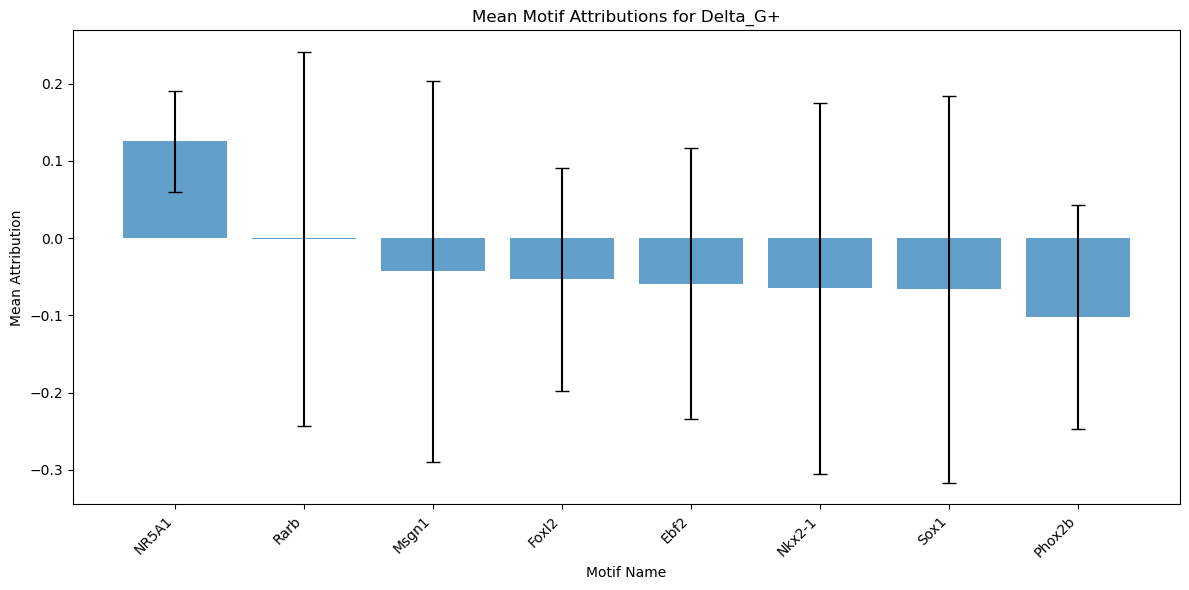

Index(['Motif_ID', 'Motif_Name', 'Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5'], dtype='object')


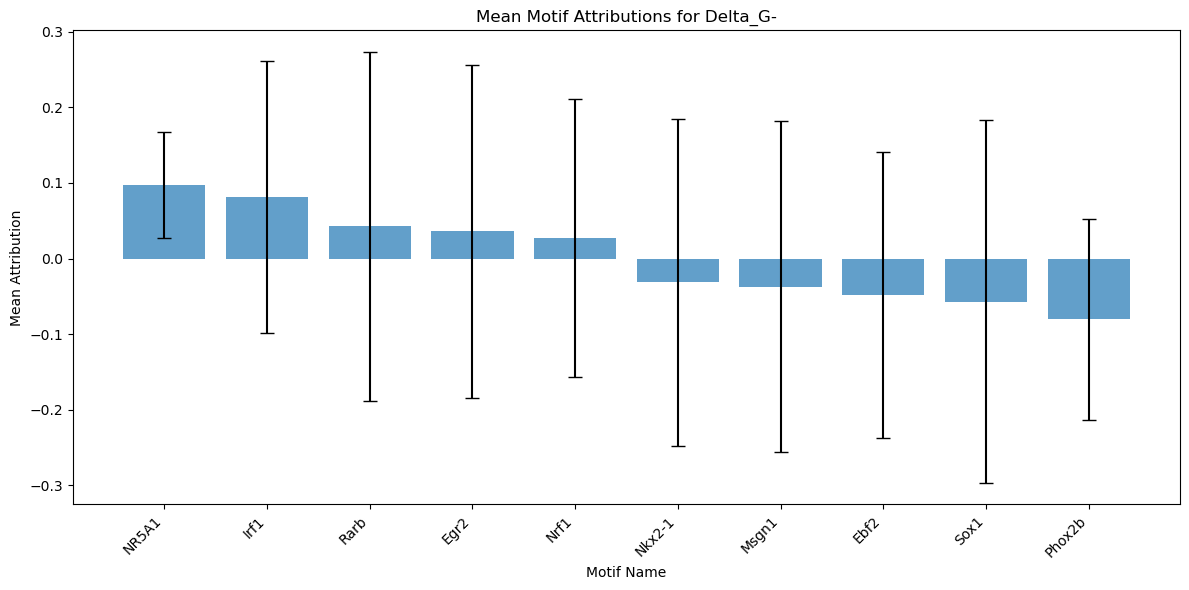

Motif_ID Motif_Name      Rep1      Rep2      Rep3  \
0    MA0472.1 MA0472.1.Egr2       Egr2 -0.012233  0.086516  0.039004   
1  MA0681.1 MA0681.1.Phox2b     Phox2b  0.022774 -0.241365 -0.139821   
2    MA0858.1 MA0858.1.Rarb       Rarb -0.039328  0.026750  0.117171   
3    MA0870.1 MA0870.1.Sox1       Sox1 -0.092633 -0.115268  0.023455   
4    MA1604.1 MA1604.1.Ebf2       Ebf2  0.157103 -0.358055 -0.040246   
5  MA1994.1 MA1994.1.Nkx2-1     Nkx2-1  0.037759 -0.261152  0.122463   
6    MA0050.3 MA0050.3.Irf1       Irf1  0.037320 -0.040917  0.219358   
7    MA0506.2 MA0506.2.Nrf1       Nrf1  0.100903  0.260777 -0.008938   
8   MA1524.2 MA1524.2.Msgn1      Msgn1 -0.156768  0.230845  0.070171   
9   MA1540.2 MA1540.2.NR5A1      NR5A1  0.156689  0.156381  0.128562   

       Rep4      Rep5      Mean  
0  0.341259 -0.274584  0.035992  
1 -0.130090  0.087876 -0.080125  
2 -0.262759  0.370721  0.042511  
3 -0.381321  0.280830 -0.056988  
4 -0.002834  0.003913 -0.048024  
5 -0.257718  0.202509 -0.031228  
6 -0.121497  0.310851  0.081023  
7  0.026261 -0.243533  0.027094  
8 -0.340506  0.011009 -0.037050  
9  0.042394  0.003460  0.097497

In [32]:
dfs = [df1, df2, df3, df4, df5]
plot_attribution(dfs, motif_intersect_pos, 'Delta_G+', "/pmglocal/ty2514/Enhancer/Enhancer/data/Marginalization/G+G-Pred_20NN/20NN_G+_attribution_plot.png")
plot_attribution(dfs, motif_intersect_neg, 'Delta_G-', "/pmglocal/ty2514/Enhancer/Enhancer/data/Marginalization/G+G-Pred_20NN/20NN_G-_attribution_plot.png")


### Analyze marginalization results for 60NN

In [42]:
df1 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/60NN_Rep1_Attributions.csv', sep = ',')
df2 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/60NN_Rep2_Attributions.csv', sep = ',')
df3 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/60NN_Rep3_Attributions.csv', sep = ',')
df4 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/60NN_Rep4_Attributions.csv', sep = ',')
df5 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/60NN_Rep5_Attributions.csv', sep = ',')

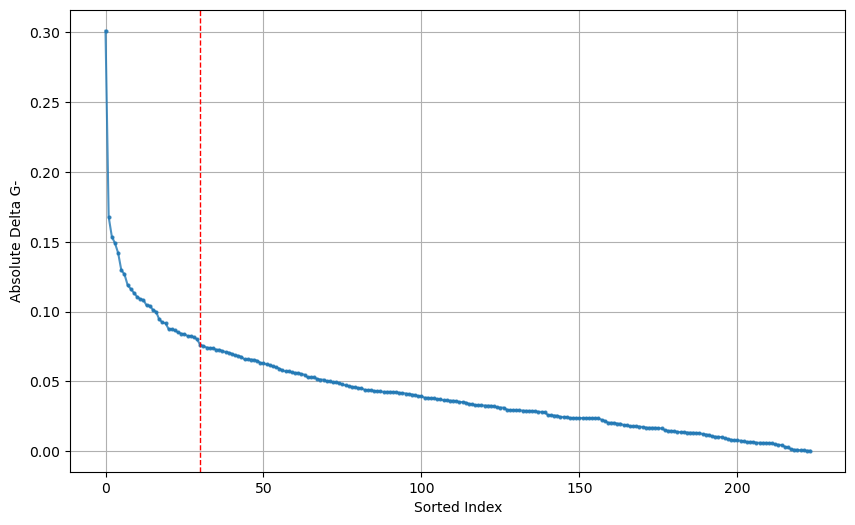

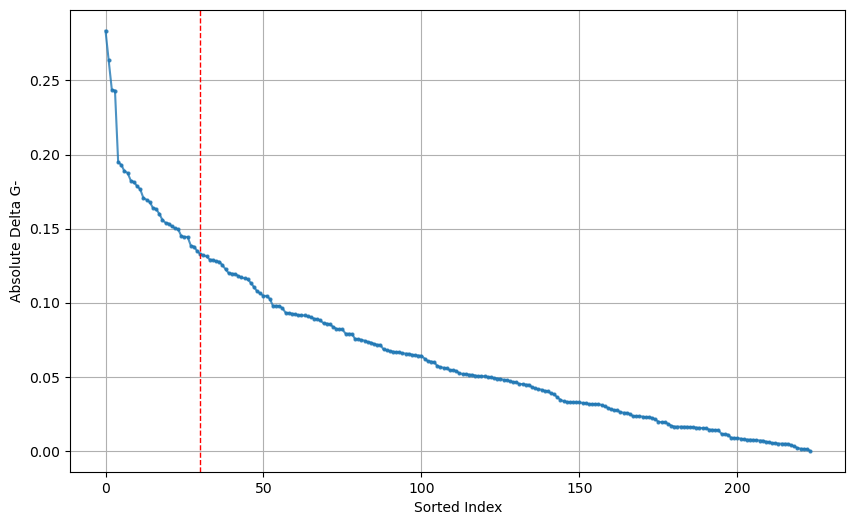

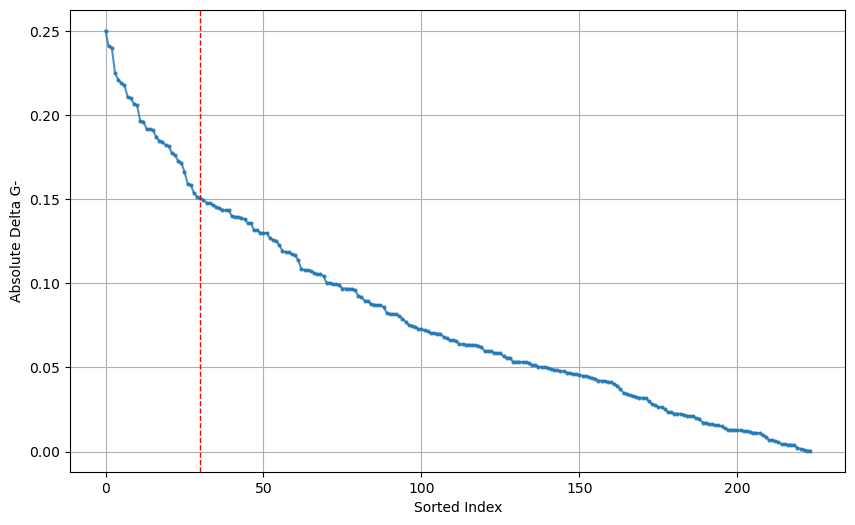

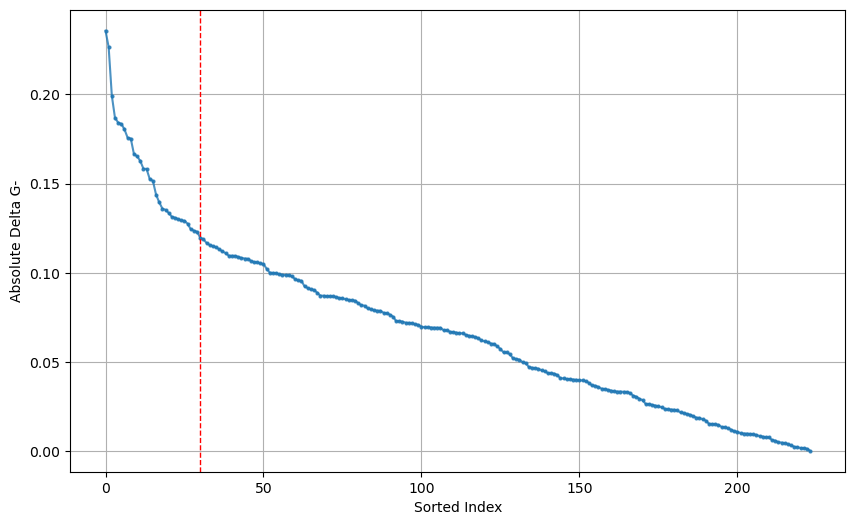

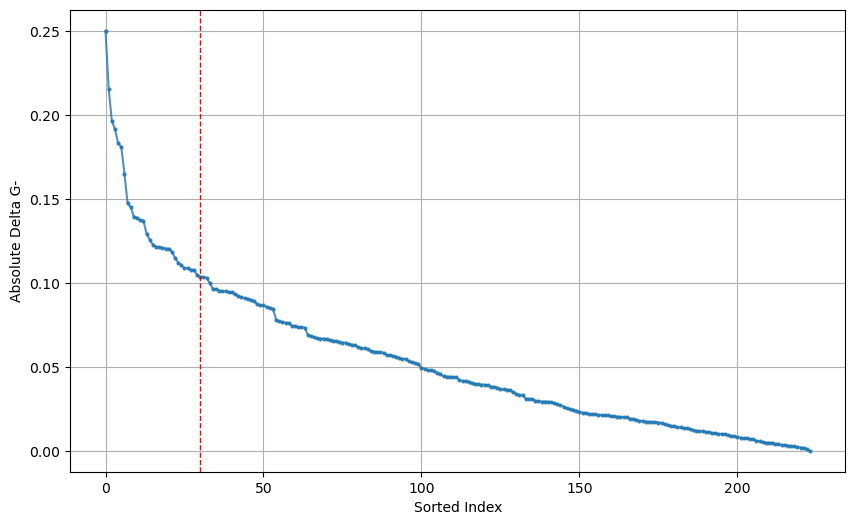

In [58]:
#sorted_df1 = find_cutoff(df1, 'G+', 19)
#sorted_df2 = find_cutoff(df2, 'G+', 23)
#sorted_df3 = find_cutoff(df3, 'G+', 30)
#sorted_df4 = find_cutoff(df4, 'G+', 21)
#sorted_df5 = find_cutoff(df5, 'G+', 20)
# For GFP+
sorted_df1_pos = find_cutoff(df1, 'G+', 30, plot = False)
sorted_df2_pos = find_cutoff(df2, 'G+', 30, plot = False)
sorted_df3_pos = find_cutoff(df3, 'G+', 30, plot = False)
sorted_df4_pos = find_cutoff(df4, 'G+', 30, plot = False)
sorted_df5_pos = find_cutoff(df5, 'G+', 30, plot = False)
# For GFP-
sorted_df1_neg = find_cutoff(df1, 'G-', 30)
sorted_df2_neg = find_cutoff(df2, 'G-', 30)
sorted_df3_neg = find_cutoff(df3, 'G-', 30)
sorted_df4_neg = find_cutoff(df4, 'G-', 30)
sorted_df5_neg = find_cutoff(df5, 'G-', 30)

/pmglocal/ty2514/miniforge3/envs/explainn/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/pmglocal/ty2514/miniforge3/envs/explainn/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

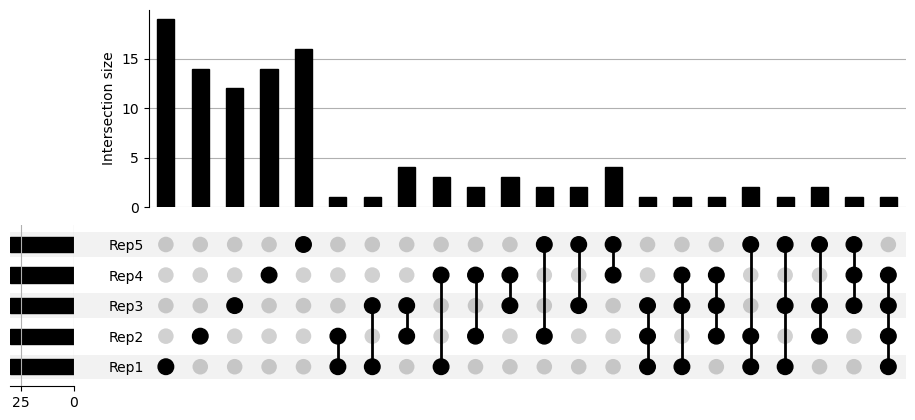

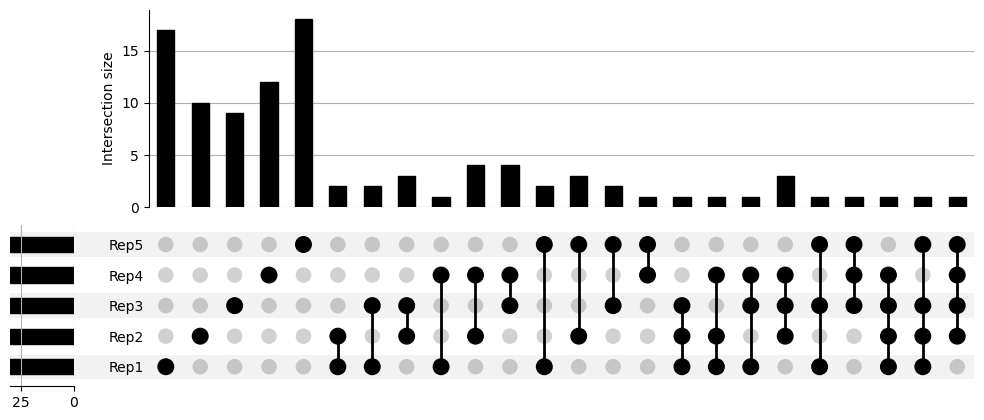

In [59]:
"""Plot upset plot"""
# GFP+
# Extract unique 'Motif_Name' values from each DataFrame
set1_pos = set(sorted_df1_pos['Motif_ID'])
set2_pos = set(sorted_df2_pos['Motif_ID'])
set3_pos = set(sorted_df3_pos['Motif_ID'])
set4_pos = set(sorted_df4_pos['Motif_ID'])
set5_pos = set(sorted_df5_pos['Motif_ID'])

set_names = ['Rep1', 'Rep2', 'Rep3','Rep4','Rep5']
all_elems = set1_pos.union(set2_pos).union(set3_pos).union(set4_pos).union(set5_pos)
df = pd.DataFrame([[e in set1_pos, e in set2_pos, e in set3_pos, e in set4_pos, e in set5_pos] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')
plt.savefig("/pmglocal/ty2514/Enhancer/Enhancer/data/Marginalization/G+G-Pred_60NN/60NN_G+_upsetplot.png", dpi=300, bbox_inches='tight')
plt.show()

# GFP-
# Extract unique 'Motif_Name' values from each DataFrame
set1_neg = set(sorted_df1_neg['Motif_ID'])
set2_neg = set(sorted_df2_neg['Motif_ID'])
set3_neg = set(sorted_df3_neg['Motif_ID'])
set4_neg = set(sorted_df4_neg['Motif_ID'])
set5_neg = set(sorted_df5_neg['Motif_ID'])

set_names = ['Rep1', 'Rep2', 'Rep3','Rep4','Rep5']
all_elems = set1_neg.union(set2_neg).union(set3_neg).union(set4_neg).union(set5_neg)
df = pd.DataFrame([[e in set1_neg, e in set2_neg, e in set3_neg, e in set4_neg, e in set5_neg] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')
plt.savefig("/pmglocal/ty2514/Enhancer/Enhancer/data/Marginalization/G+G-Pred_60NN/60NN_G-_upsetplot.png", dpi=300, bbox_inches='tight')
plt.show()

"""Plot Venn Diagram"""
#dict of sets
sets = {
    'Rep2': set2,
    'Rep3': set3,
    'Rep4': set4,
    'Rep5': set5}

#venny4py(sets=sets)

In [62]:
sets_pos = {
    'Rep1': set1_pos,
    'Rep2': set2_pos,
    'Rep3': set3_pos,
    'Rep4': set4_pos,
    'Rep5': set5_pos}

sets_neg = {
    'Rep1': set1_neg,
    'Rep2': set2_neg,
    'Rep3': set3_neg,
    'Rep4': set4_neg,
    'Rep5': set5_neg}

motif_intersect_pos = find_interect_ID(sets_pos, 3)
print(len(motif_intersect_pos))

motif_intersect_neg = find_interect_ID(sets_neg, 3)
print(len(motif_intersect_neg))

Motif names occurring in at least 3 sets: {'MA0493.1 MA0493.1.Klf1', 'MA1627.1 MA1627.1.Wt1', 'MA0627.1 MA0627.1.Pou2f3', 'MA0693.1 MA0693.1.Vdr', 'MA1990.1 MA1990.1.Gli1', 'MA0858.1 MA0858.1.Rarb', 'MA0113.1 MA0113.1.NR3C1', 'MA0467.1 MA0467.1.Crx', 'MA0472.1 MA0472.1.Egr2', 'MA0060.1 MA0060.1.NFYA'}
10
Motif names occurring in at least 3 sets: {'MA0493.1 MA0493.1.Klf1', 'MA0050.3 MA0050.3.Irf1', 'MA1627.1 MA1627.1.Wt1', 'MA1604.1 MA1604.1.Ebf2', 'MA0869.1 MA0869.1.Sox11', 'MA0857.1 MA0857.1.Rarb', 'MA0627.1 MA0627.1.Pou2f3', 'MA0693.1 MA0693.1.Vdr', 'MA1629.1 MA1629.1.Zic2', 'MA0469.1 MA0469.1.E2F3', 'MA0472.1 MA0472.1.Egr2'}
11


Index(['Motif_ID', 'Motif_Name', 'Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5'], dtype='object')


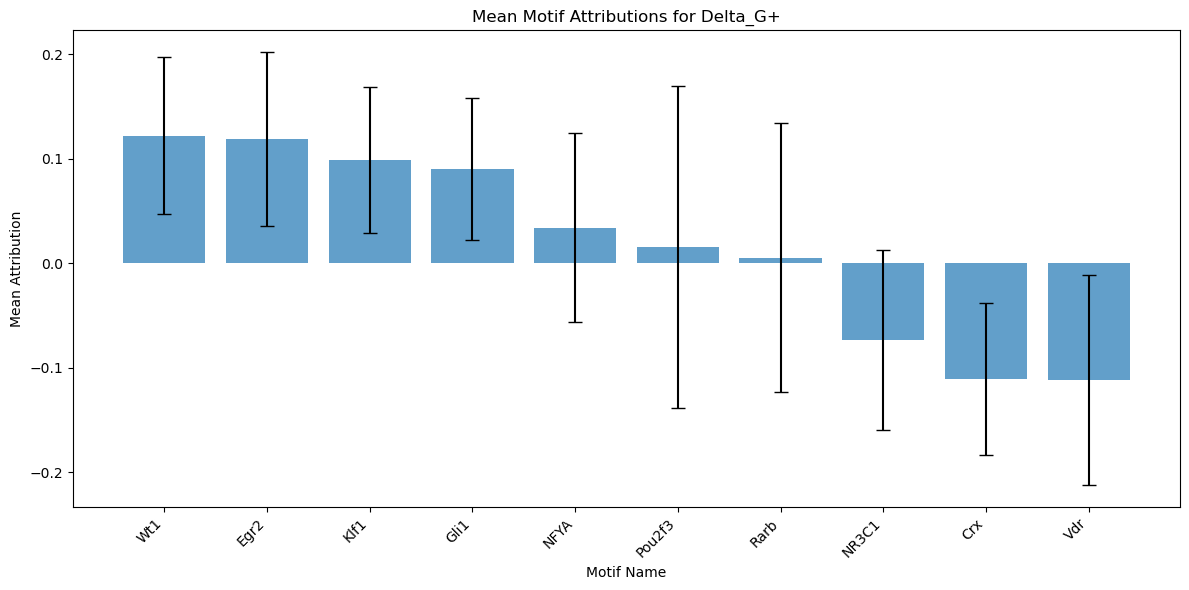

Index(['Motif_ID', 'Motif_Name', 'Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5'], dtype='object')


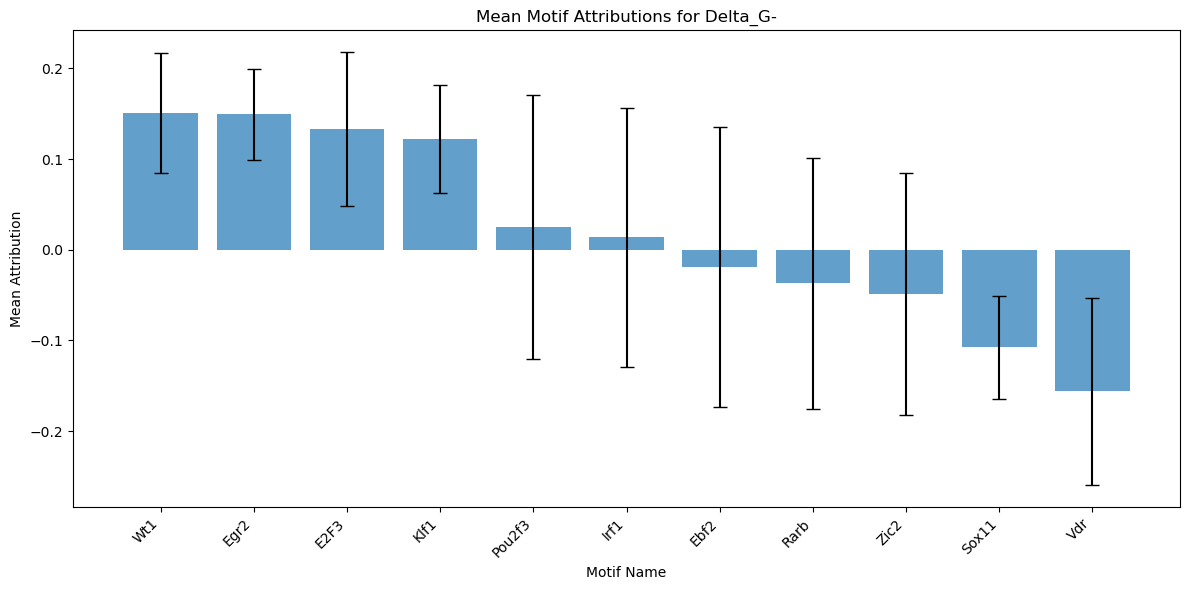

Motif_ID Motif_Name      Rep1      Rep2      Rep3  \
0     MA0469.1 MA0469.1.E2F3       E2F3  0.099893  0.263492  0.153513   
1     MA0472.1 MA0472.1.Egr2       Egr2  0.104419  0.176509  0.209973   
2     MA0493.1 MA0493.1.Klf1       Klf1  0.104265  0.044689  0.181404   
3   MA0627.1 MA0627.1.Pou2f3     Pou2f3  0.080188  0.129072 -0.219163   
4      MA0693.1 MA0693.1.Vdr        Vdr -0.148965 -0.243753 -0.166254   
5     MA0857.1 MA0857.1.Rarb       Rarb  0.023663 -0.155935 -0.206686   
6    MA0869.1 MA0869.1.Sox11      Sox11 -0.085063 -0.150233 -0.070250   
7     MA1604.1 MA1604.1.Ebf2       Ebf2 -0.013033  0.178696 -0.205671   
8      MA1627.1 MA1627.1.Wt1        Wt1  0.062150  0.243155  0.172765   
9     MA1629.1 MA1629.1.Zic2       Zic2  0.000600 -0.031642 -0.177540   
10    MA0050.3 MA0050.3.Irf1       Irf1 -0.041648  0.181346 -0.151459   

        Rep4      Rep5      Mean  
0   0.115574  0.033152  0.133125  
1   0.090442  0.165059  0.149281  
2   0.184162  0.095459  0.121996  
3   0.006006  0.129309  0.025083  
4  -0.235579  0.012959 -0.156318  
5   0.122984  0.030980 -0.036999  
6  -0.183427 -0.049440 -0.107683  
7  -0.131380  0.076765 -0.018925  
8   0.129327  0.147324  0.150944  
9  -0.175664  0.139365 -0.048976  
10  0.143789 -0.063213  0.013763

In [63]:
dfs = [df1, df2, df3, df4, df5]
plot_attribution(dfs, motif_intersect_pos, 'Delta_G+')
plot_attribution(dfs, motif_intersect_neg, 'Delta_G-')

### Analyze marginalization results for 75NN

In [3]:
df1 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/75NN_Rep1_Attributions.csv', sep = ',')
df2 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/75NN_Rep2_Attributions.csv', sep = ',')
df3 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/75NN_Rep3_Attributions.csv', sep = ',')
df4 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/75NN_Rep4_Attributions.csv', sep = ',')
df5 = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/75NN_Rep5_Attributions.csv', sep = ',')


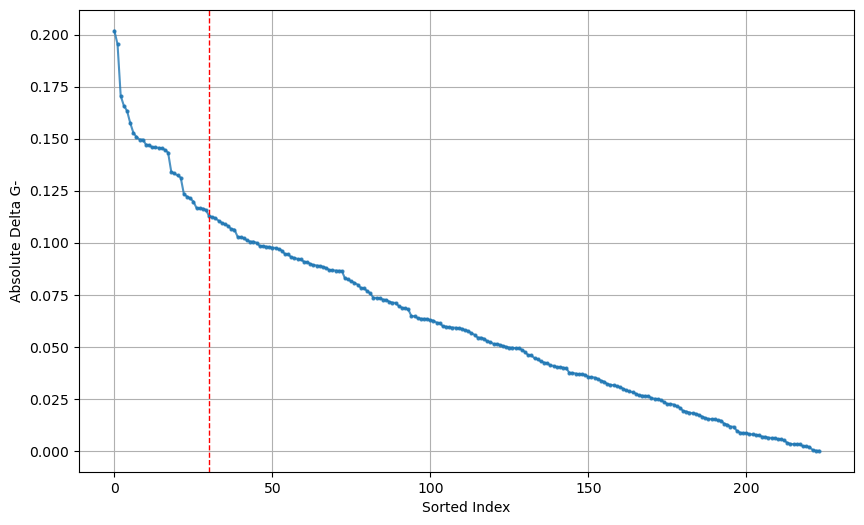

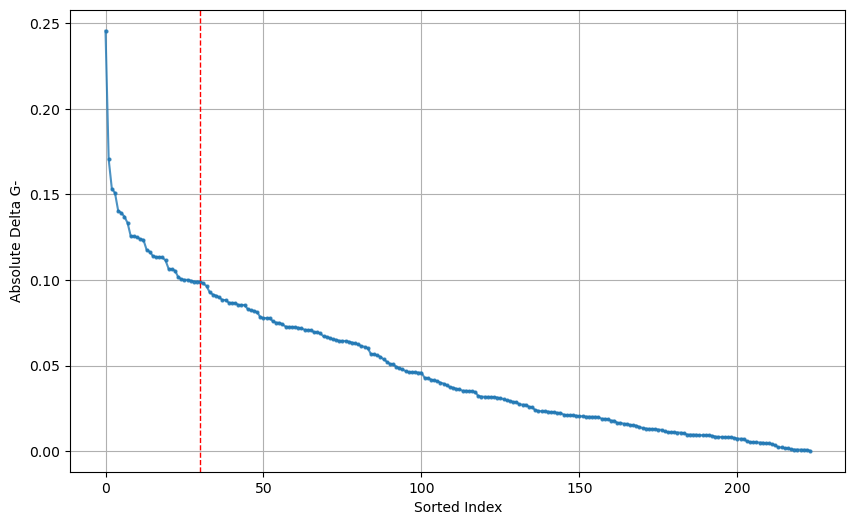

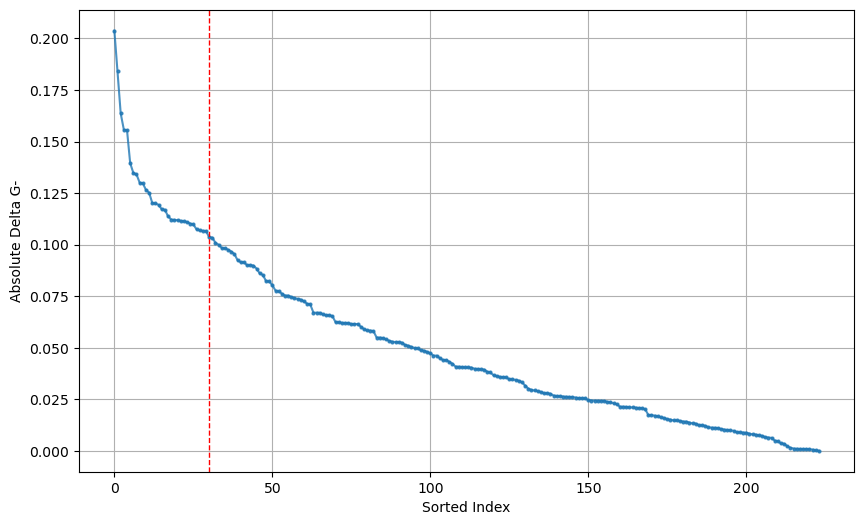

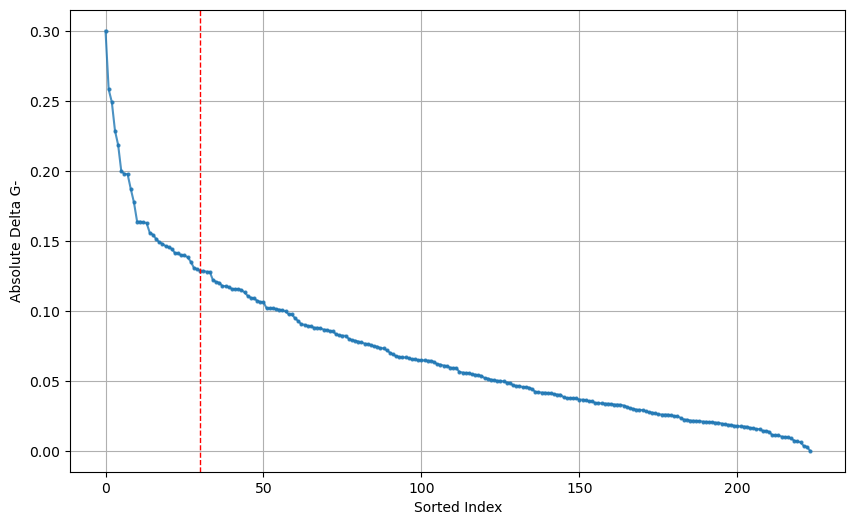

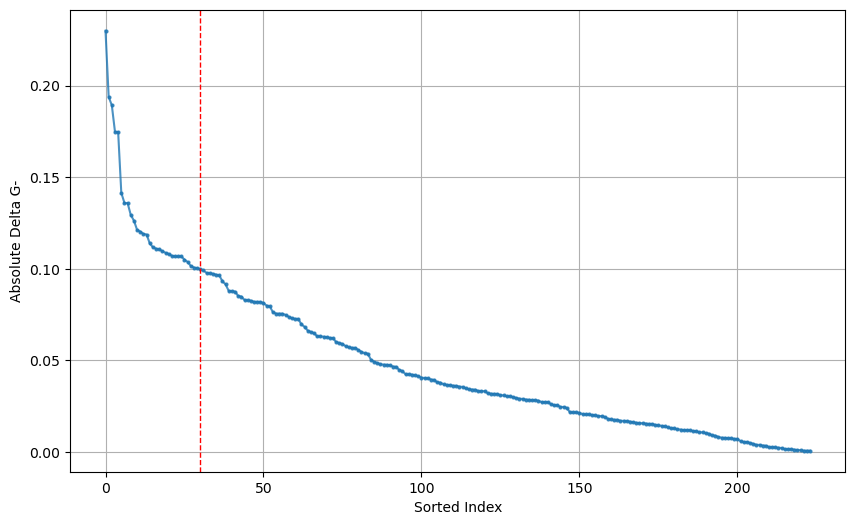

In [10]:
# For GFP+
sorted_df1_pos = find_cutoff(df1, 'G+', 30, plot = False)
sorted_df2_pos = find_cutoff(df2, 'G+', 30, plot = False)
sorted_df3_pos = find_cutoff(df3, 'G+', 30, plot = False)
sorted_df4_pos = find_cutoff(df4, 'G+', 30, plot = False)
sorted_df5_pos = find_cutoff(df5, 'G+', 30, plot = False)
# For GFP-
sorted_df1_neg = find_cutoff(df1, 'G-', 30)
sorted_df2_neg = find_cutoff(df2, 'G-', 30)
sorted_df3_neg = find_cutoff(df3, 'G-', 30)
sorted_df4_neg = find_cutoff(df4, 'G-', 30)
sorted_df5_neg = find_cutoff(df5, 'G-', 30)

/pmglocal/ty2514/miniforge3/envs/explainn/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/pmglocal/ty2514/miniforge3/envs/explainn/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

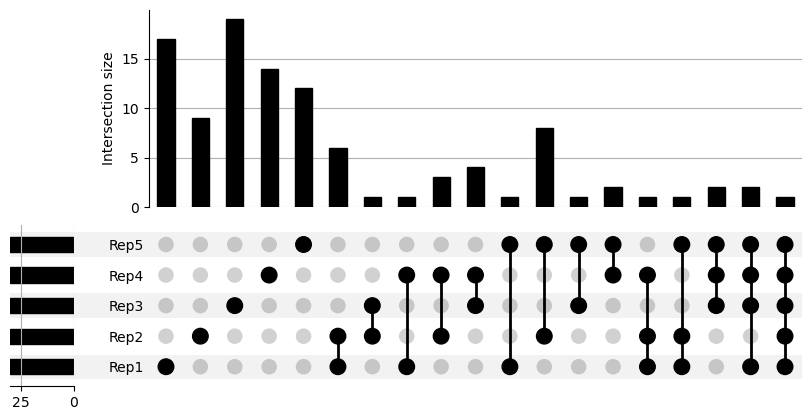

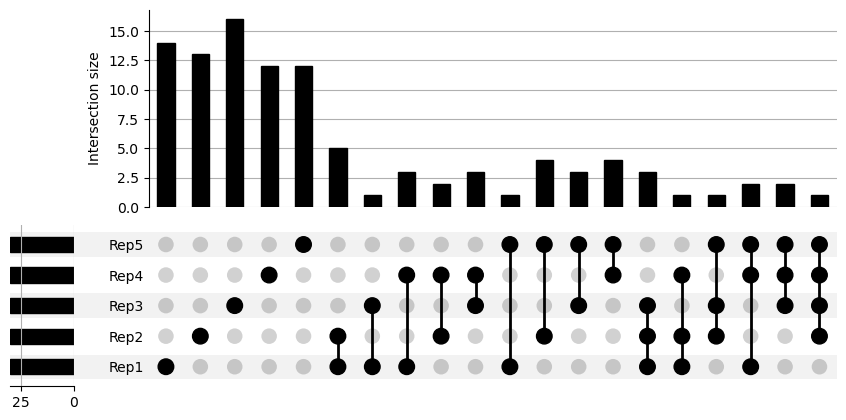

In [11]:
"""Plot upset plot"""
# GFP+
# Extract unique 'Motif_Name' values from each DataFrame
set1_pos = set(sorted_df1_pos['Motif_ID'])
set2_pos = set(sorted_df2_pos['Motif_ID'])
set3_pos = set(sorted_df3_pos['Motif_ID'])
set4_pos = set(sorted_df4_pos['Motif_ID'])
set5_pos = set(sorted_df5_pos['Motif_ID'])

set_names = ['Rep1', 'Rep2', 'Rep3','Rep4','Rep5']
all_elems = set1_pos.union(set2_pos).union(set3_pos).union(set4_pos).union(set5_pos)
df = pd.DataFrame([[e in set1_pos, e in set2_pos, e in set3_pos, e in set4_pos, e in set5_pos] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')
plt.savefig("/pmglocal/ty2514/Enhancer/Enhancer/data/Marginalization/G+G-Pred_75NN/75NN_G+_upsetplot.png", dpi=300, bbox_inches='tight')
plt.show()

# GFP-
# Extract unique 'Motif_Name' values from each DataFrame
set1_neg = set(sorted_df1_neg['Motif_ID'])
set2_neg = set(sorted_df2_neg['Motif_ID'])
set3_neg = set(sorted_df3_neg['Motif_ID'])
set4_neg = set(sorted_df4_neg['Motif_ID'])
set5_neg = set(sorted_df5_neg['Motif_ID'])

set_names = ['Rep1', 'Rep2', 'Rep3','Rep4','Rep5']
all_elems = set1_neg.union(set2_neg).union(set3_neg).union(set4_neg).union(set5_neg)
df = pd.DataFrame([[e in set1_neg, e in set2_neg, e in set3_neg, e in set4_neg, e in set5_neg] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')
plt.savefig("/pmglocal/ty2514/Enhancer/Enhancer/data/Marginalization/G+G-Pred_75NN/75NN_G-_upsetplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
sets_pos = {
    'Rep1': set1_pos,
    'Rep2': set2_pos,
    'Rep3': set3_pos,
    'Rep4': set4_pos,
    'Rep5': set5_pos}

sets_neg = {
    'Rep1': set1_neg,
    'Rep2': set2_neg,
    'Rep3': set3_neg,
    'Rep4': set4_neg,
    'Rep5': set5_neg}

motif_intersect_pos = find_interect_ID(sets_pos, 3)
print(len(motif_intersect_pos))

motif_intersect_neg = find_interect_ID(sets_neg, 3)
print(len(motif_intersect_neg))

Motif names occurring in at least 3 sets: {'MA1573.2 MA1573.2.Thap11', 'MA0734.3 MA0734.3.Gli2', 'MA1990.1 MA1990.1.Gli1', 'MA1630.1 MA1630.1.Znf281', 'MA1607.1 MA1607.1.Foxl2', 'MA0616.1 MA0616.1.Hes2', 'MA0472.1 MA0472.1.Egr2'}
7
Motif names occurring in at least 3 sets: {'MA0068.1 MA0068.1.Pax4', 'MA0079.2 MA0079.2.SP1', 'MA1573.2 MA1573.2.Thap11', 'MA0734.3 MA0734.3.Gli2', 'MA0659.3 MA0659.3.Mafg', 'MA1630.1 MA1630.1.Znf281', 'MA0114.3 MA0114.3.Hnf4a', 'MA0080.3 MA0080.3.Spi1', 'MA0472.1 MA0472.1.Egr2', 'MA0912.1 MA0912.1.Hoxd3'}
10


Index(['Motif_ID', 'Motif_Name', 'Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5'], dtype='object')


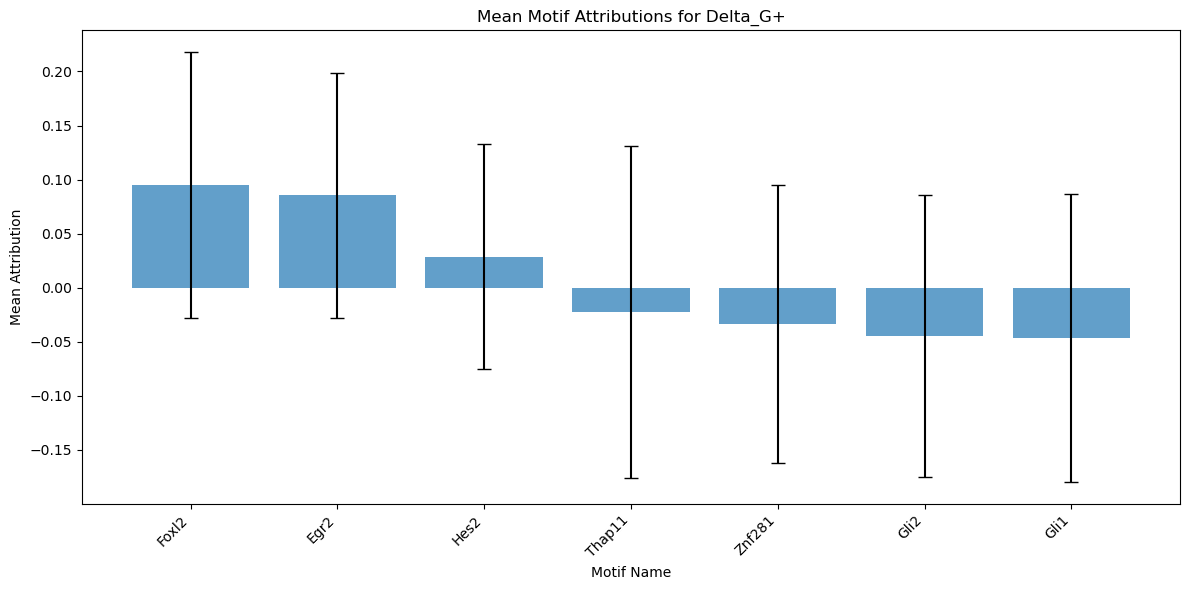

Index(['Motif_ID', 'Motif_Name', 'Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5'], dtype='object')


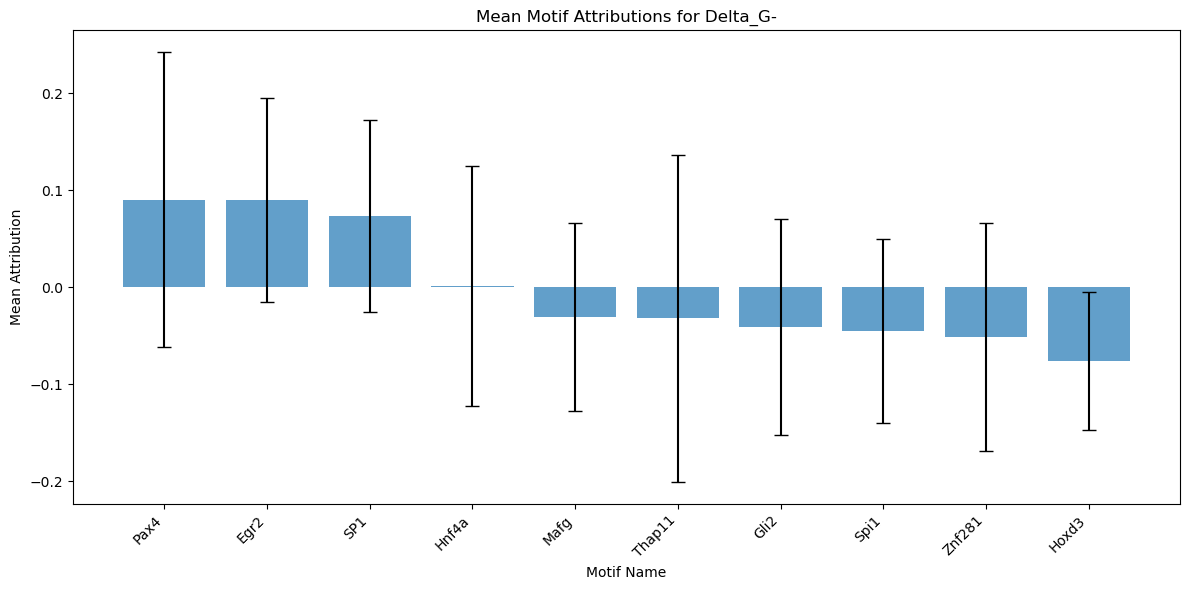

Motif_ID Motif_Name      Rep1      Rep2      Rep3  \
0    MA0068.1 MA0068.1.Pax4       Pax4  0.005649  0.140604  0.111831   
1     MA0079.2 MA0079.2.SP1        SP1  0.134093  0.106353  0.049837   
2    MA0472.1 MA0472.1.Egr2       Egr2  0.145730  0.125567  0.155472   
3    MA0080.3 MA0080.3.Spi1       Spi1 -0.040233 -0.125533 -0.107428   
4   MA0114.3 MA0114.3.Hnf4a      Hnf4a -0.045919 -0.077702 -0.134074   
5   MA0912.1 MA0912.1.Hoxd3      Hoxd3 -0.144639 -0.099150 -0.134787   
6  MA1630.1 MA1630.1.Znf281     Znf281 -0.007476 -0.036486 -0.125201   
7    MA0659.3 MA0659.3.Mafg       Mafg -0.116696  0.117769 -0.110980   
8    MA0734.3 MA0734.3.Gli2       Gli2 -0.123354  0.012482 -0.103588   
9  MA1573.2 MA1573.2.Thap11     Thap11 -0.201822 -0.082284  0.030215   

       Rep4      Rep5      Mean  
0  0.300083 -0.106706  0.090292  
1  0.163807 -0.087549  0.073308  
2  0.117703 -0.096372  0.089620  
3 -0.066872  0.113883 -0.045237  
4  0.145505  0.119040  0.001370  
5 -0.017545  0.014804 -0.076263  
6 -0.197975  0.110581 -0.051312  
7  0.003646 -0.047832 -0.030819  
8  0.130721 -0.121205 -0.040989  
9  0.228708 -0.135890 -0.032215

In [13]:
dfs = [df1, df2, df3, df4, df5]
plot_attribution(dfs, motif_intersect_pos, 'Delta_G+')
plot_attribution(dfs, motif_intersect_neg, 'Delta_G-')

### Run an example

In [ ]:
motifs = read_meme("/pmglocal/ty2514/Enhancer/motif-clustering/databases/jaspar2024/JASPAR2024_CORE_vertebrates_mus_musculus_non-redundant_pfms_with_id.meme")
num_cnns = 20
reps = 5

print(f'Now processing CNN:{num_cnn}, Rep:{rep}')
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Metrics.csv')
temp_df = params[params['num_cnns'] == num_cnn]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]

seed = best_seed
batch = best_batch
learning_rate= best_lr

print(f'cnn: {num_cnn}')
print(f'lr: {learning_rate}    drop_out: {best_dropout}')
print(f'batch: {batch}    seed: {seed}')

weight_folder = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/{num_cnn}NN_Rep{rep}'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Initialize the model without moving it to the device yet
explainn = ExplaiNN3(num_cnns=num_cnn, input_length=608, num_classes=2,
                    filter_size=19, num_fc=2, pool_size=7, pool_stride=7,
                    drop_out=0.3, weight_path=None)  # Training

file_list = glob.glob(f'{weight_folder}/best_pearson*.pth')
weight_file = file_list[0]
print(f"Extracting from {weight_file}")
state_dict = torch.load(weight_file, map_location=device)  # Load to the appropriate device
# Load the modified state_dict into the model
explainn.load_state_dict(state_dict)

# Move the model to the appropriate device after loading the weights
explainn.to(device)
explainn.eval()

##### Run marginalization with the defined model
names = []
deltas_G_plus = []
deltas_G_minus = []

for name, pwm in motifs.items():
    consensus = pwm_consensus(pwm).unsqueeze(0)
    y_before, y_after = marginalize(explainn, X, consensus, device = 'cuda')
    
    # Calculate deltas for G+ and G-
    delta_G_plus = (y_after[:, 0] - y_before[:, 0]).mean().item()  # For G+
    delta_G_minus = (y_after[:, 1] - y_before[:, 1]).mean().item()  # For G-

    # Store results
    names.append(name)
    deltas_G_plus.append(delta_G_plus)
    deltas_G_minus.append(delta_G_minus)

    print(f"{name} - ΔG+: {delta_G_plus}, ΔG-: {delta_G_minus}")

# Construct a data frame using names, delta_G_plus and delta_G_minus lists
filtered_names = [name.split('.')[-1] for name in names]
df = pd.DataFrame({'Motif_ID': names, 'Motif_Name': filtered_names, 'Delta_G+': deltas_G_plus, 'Delta_G-': deltas_G_minus})

In [6]:
names = []
deltas_G_plus = []
deltas_G_minus = []

for name, pwm in motifs.items():
    consensus = pwm_consensus(pwm).unsqueeze(0)
    y_before, y_after = marginalize(explainn, X, consensus, device = 'cpu')
    
    # Calculate deltas for G+ and G-
    delta_G_plus = (y_after[:, 0] - y_before[:, 0]).mean().item()  # For G+
    delta_G_minus = (y_after[:, 1] - y_before[:, 1]).mean().item()  # For G-

    # Store results
    names.append(name)
    deltas_G_plus.append(delta_G_plus)
    deltas_G_minus.append(delta_G_minus)

    print(f"{name} - ΔG+: {delta_G_plus}, ΔG-: {delta_G_minus}")


MA0004.1 MA0004.1.Arnt - ΔG+: -0.03601390868425369, ΔG-: -0.03770679235458374
MA0006.1 MA0006.1.Ahr::Arnt - ΔG+: -0.06446895748376846, ΔG-: -0.07395349442958832
MA0009.1 MA0009.1.Tbxt - ΔG+: 0.0364358089864254, ΔG-: 0.04726005718111992
MA0014.1 MA0014.1.Pax5 - ΔG+: 0.10224387049674988, ΔG-: 0.13939160108566284
MA0027.1 MA0027.1.En1 - ΔG+: 0.0669691264629364, ΔG-: 0.0599990040063858
MA0029.1 MA0029.1.Mecom - ΔG+: 0.017099076882004738, ΔG-: 0.029166346415877342
MA0035.1 MA0035.1.Gata1 - ΔG+: 0.018344100564718246, ΔG-: 0.023498183116316795
MA0039.1 MA0039.1.Klf4 - ΔG+: 0.022049633786082268, ΔG-: 0.010858403518795967
MA0060.1 MA0060.1.NFYA - ΔG+: 0.3281397521495819, ΔG-: 0.35295310616493225
MA0105.1 MA0105.1.NFKB1 - ΔG+: 0.007887422107160091, ΔG-: -0.009187513031065464
MA0063.1 MA0063.1.Nkx2-5 - ΔG+: 0.07173138856887817, ΔG-: 0.07774126529693604
MA0067.1 MA0067.1.Pax2 - ΔG+: 0.009391291998326778, ΔG-: -0.000753080821596086
MA0068.1 MA0068.1.Pax4 - ΔG+: -0.043758075684309006, ΔG-: -0.035631

KeyboardInterrupt: 

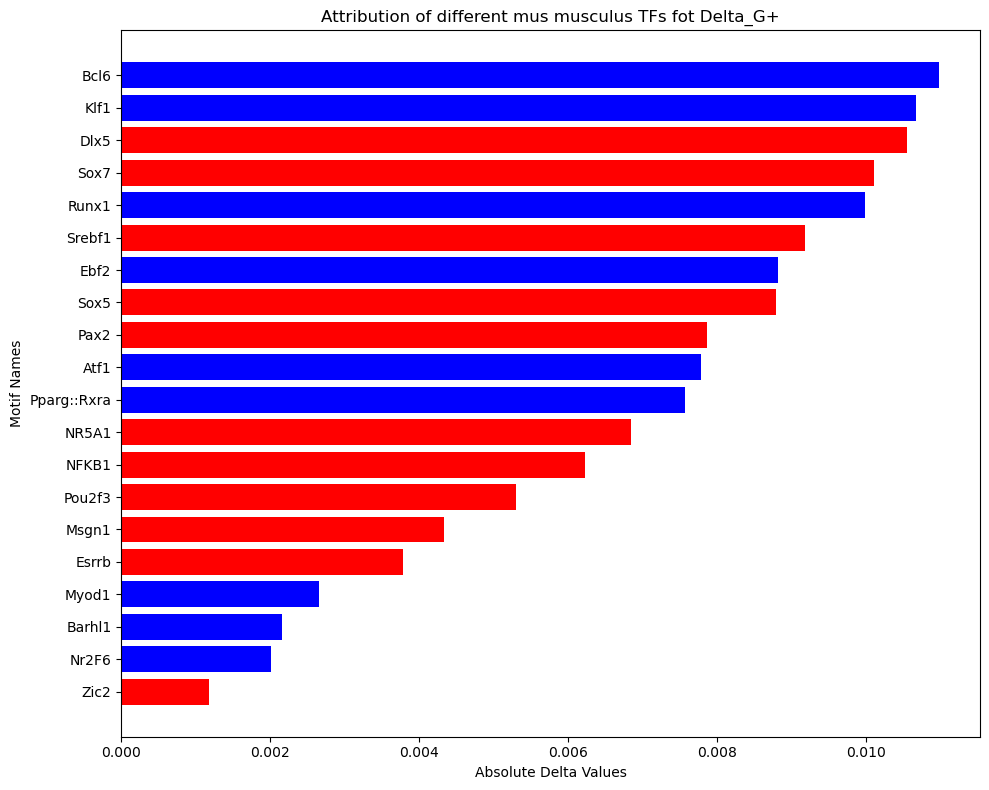

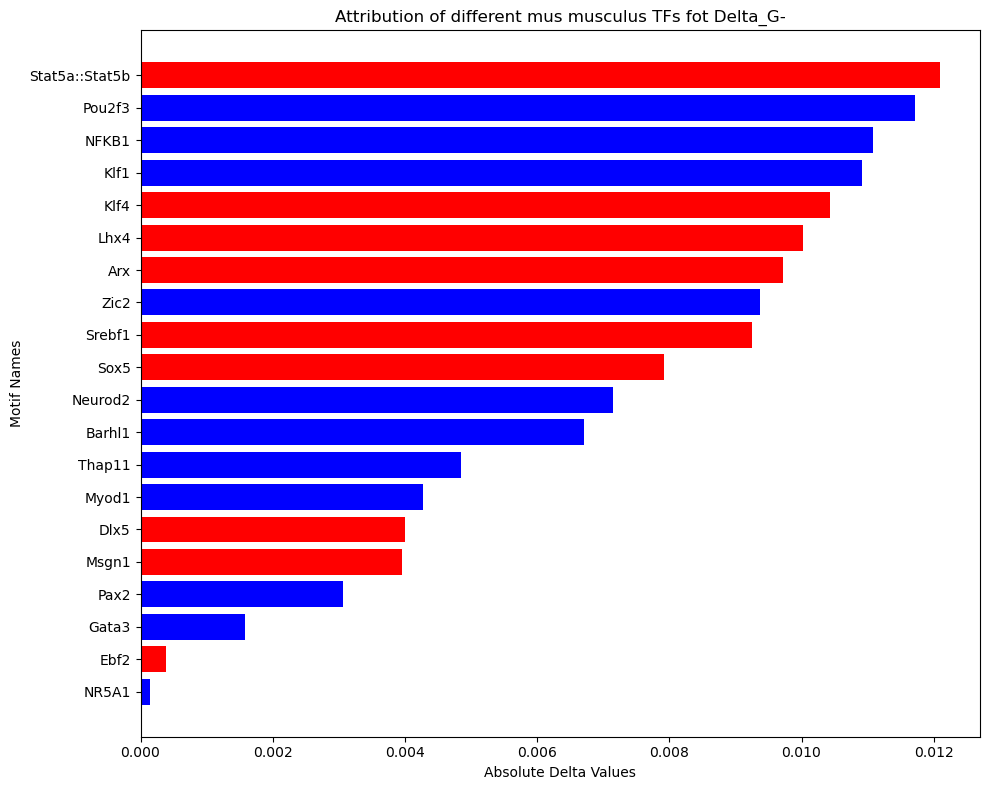

In [33]:
# Create DataFrame
filtered_names = [name.split('.')[-1] for name in names]

df = pd.DataFrame({'Motif_ID': names, 'Motif_Name': filtered_names, 'Delta_G+': deltas_G_plus, 'Delta_G-': deltas_G_minus})
#df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/Atributions/60NN_Rep_Attributions.csv')

plot_delta(df, 'Delta_G+', 20)
plot_delta(df, 'Delta_G-', 20)



In [ ]:
from tangermeme.plot import plot_pwm

# Iterate over each row in the DataFrame
for _, row in top_20.iterrows():
    motif_id = row['Motif_ID']  
    motif_name = row['Motif_Name']  
    
    # Call the plot_pwm function
    plot_pwm(motifs[motif_id], motif_name)


## Seqlet Calling + TOMTOM

### Define model

In [3]:
num_cnns = 75
rep = 8

params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Metrics.csv')
temp_df = params[params['num_cnns'] == num_cnns]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]

seed = best_seed
batch = best_batch
learning_rate= best_lr

print(f'cnn: {num_cnns}')
print(f'lr: {learning_rate}    drop_out: {best_dropout}')
print(f'batch: {batch}    seed: {seed}')

weight_folder = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/{num_cnns}NN_Rep{rep}'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Initialize the model without moving it to the device yet
explainn = ExplaiNN3(num_cnns=num_cnns, input_length=608, num_classes=2,
                    filter_size=19, num_fc=2, pool_size=7, pool_stride=7,
                    drop_out=0.3, weight_path=None)  # Training

file_list = glob.glob(f'{weight_folder}/best_pearson*.pth')
weight_file = file_list[0]
print(f"Extracting from {weight_file}")
state_dict = torch.load(weight_file, map_location=device)  # Load to the appropriate device
# Load the modified state_dict into the model
explainn.load_state_dict(state_dict)

# Move the model to the appropriate device after loading the weights
explainn.to(device)
explainn.eval()

motifs = read_meme("/pmglocal/ty2514/Enhancer/motif-clustering/databases/jaspar2024/JASPAR2024_CORE_vertebrates_mus_musculus_non-redundant_pfms_with_id.meme")


cnn: 75
lr: 0.0001    drop_out: 0.3
batch: 168    seed: 350
cuda
Extracting from /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/75NN_Rep8/best_pearson_model_epoch_85.pth


### Run DeepLift and Seqlet Calling

In [4]:
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_merged_data.csv')

# Assuming 'sequence' column contains DNA sequences
sequences = df['sequence'].values  # Extract sequences as a NumPy array

# Convert sequences to one-hot encodings
one_hot_encodings = [dna_one_hot(seq) for seq in sequences]

# Stack the one-hot encoded arrays along the first dimension
X = np.stack(one_hot_encodings, axis=0)  # Shape: [n_samples, 4, dna_length]

# Convert to a PyTorch tensor
X = torch.tensor(X, dtype=torch.float32)  # Shape: [n_samples, 4, dna_length]
print(X.shape)


torch.Size([14301, 4, 608])


In [5]:
additional_nonlinear_ops = {ExpActivation : exp_rescale_rule}
X_attr_Gpos = deep_lift_shap(explainn, X, target = 0, device='cuda', batch_size=best_batch, n_shuffles=20, additional_nonlinear_ops=additional_nonlinear_ops, random_state=0, warning_threshold=0.1, verbose=True)
#X_attr_Gneg = deep_lift_shap(explainn, X, target = 1, device='cpu', batch_size=best_batch, n_shuffles=20, random_state=0, warning_threshold=0.1, verbose=True)


  0%|          | 0/286020 [00:00<?, ?it/s]

/pmglocal/ty2514/miniforge3/envs/explainn/lib/python3.10/site-packages/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([1.9960, 0.9516, 2.7349, 1.1533, 1.8635, 0.8623, 0.4253, 0.0503, 1.1776,
        1.0399, 1.1711, 1.7612, 1.0166, 2.5448, 2.0653, 0.0797, 2.6909, 1.3671,
        0.5546, 2.8989, 0.3235, 1.7577, 1.1412, 2.5933, 1.2313, 0.7284, 0.3356,
        1.3399, 1.7666, 1.1109, 2.7124, 0.5511, 2.0204, 0.7757, 3.0911, 0.1877,
        0.8754, 2.2038, 0.4501, 0.7900, 0.6786, 0.1050, 2.4826, 1.3420, 1.1839,
        0.4956, 0.1661, 2.6111, 0.6196, 1.9930, 1.6502, 0.7740, 1.0882, 1.7239,
        1.2594, 1.1939, 0.2539, 1.2579, 2.5300, 1.0436, 0.8863, 0.6067, 0.6122,
        0.6381, 2.1326, 1.7704, 2.3386, 1.7078, 1.6654, 1.1339, 0.0545, 0.3274,
        0.3027, 0.9324, 0.1169, 1.0361, 0.9024, 2.1681, 0.4929, 0.2431, 0.3669,
        1.1015, 0.0126, 0.3964, 1.4440, 1.7478, 1.8660, 1.2308, 1.1102, 2.1493,
        1.1394, 0.1609, 0.8825, 0.6635, 0.8769, 1.

In [6]:
X_attr_Gpos.shape

torch.Size([14301, 4, 608])

In [9]:
X_attr_Gpos[:1,:,:20]

tensor([[[ 0.0000, -0.0003,  0.0051,  0.0004,  0.0010,  0.0008,  0.0172,
          -0.0245,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
           0.0720,  0.0000, -0.0346,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000, -0.0076,  0.0000, -0.0266,  0.0000, -0.0146,
          -0.0000,  0.0000,  0.0000, -0.0000, -0.0782,  0.0051],
         [-0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,
           0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
          -0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000],
         [ 0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
           0.0000, -0.0343, -0.0000, -0.0353,  0.0000, -0.0377,  0.0000,
           0.0000, -0.0261,  0.0000, -0.0323, -0.0000, -0.0000]]])

In [10]:
seqlets = recursive_seqlets(X_attr_Gpos.sum(dim=1), additional_flanks=5)
seqlets

example_idx  start  end  attribution   p-value
0            10057    134  148    -0.427684  0.000032
1             2157    362  379     1.951383  0.000039
2            12447    362  379     1.880671  0.000040
3            11286    362  379     1.905096  0.000043
4             3865    362  379     1.873709  0.000044
...            ...    ...  ...          ...       ...
10365          129    511  525     0.693645  0.009844
10366         3697    215  230     0.918506  0.009888
10367         8504    166  180     0.789203  0.009888
10368        12678    521  536     1.065123  0.009888
10369        10205    282  296     0.003540  0.009901

[10370 rows x 5 columns]

In [11]:
meme_file = "/pmglocal/ty2514/Enhancer/motif-clustering/databases/jaspar2024/JASPAR2024_CORE_vertebrates_mus_musculus_non-redundant_pfms_with_id.meme"
motif_idxs = annotate_seqlets(X, seqlets, meme_file)[0][:, 0]


In [12]:
y = count_annotations((seqlets['example_idx'], motif_idxs))
print(y.shape)
motif_names = np.array(list(motifs.keys()))

y_sum = y.sum(dim=0)
idxs = torch.flip(torch.argsort(y_sum), dims=(-1,))

#names = motif_names[idxs[:30]]
y

torch.Size([14301, 224])


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)